#Szöveg-feldolgozás

*   Szógyakoriság elemzése és szófelhő készítése a leggyakoribb szavakból
*   N-gramok készítése a gyakran együtt előforduló szókapcsolatok azonosítására



In [3]:
!pip install pyspark
import pandas as pd
from nltk import FreqDist
import re
from pyspark.sql.functions import split, regexp_replace
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.sql.functions import length
from pyspark.sql.functions import avg

In [4]:
#Spark session létrehozása
spark = SparkSession.builder.appName("NLP").getOrCreate()

NameError: name 'SparkSession' is not defined

In [6]:
#A tisztított adathalmaz betöltése
data = spark.read.csv("cleaned_train.csv",header = True, inferSchema = True )

In [9]:
#Szükséges oszlopok átalakítása listává
data = data.withColumn("title_tokens", split(regexp_replace("title_tokens", "[\\[\\]]", ""), ","))
data = data.withColumn("text_tokens", split(regexp_replace("text_tokens", "[\\[\\]]", ""), ","))

In [11]:
#Adatok megtekintése
data.show()

+---+---------+--------------------+--------------------+--------------------+--------------------+
|_c0|sentiment|               title|                text|        title_tokens|         text_tokens|
+---+---------+--------------------+--------------------+--------------------+--------------------+
|  0|        2|stuning even for ...|this sound track ...|['stuning',  'eve...|['sound',  'track...|
|  1|        2|the best soundtra...|im reading a lot ...|['best',  'soundt...|['im',  'reading'...|
|  2|        2|             amazing|this soundtrack i...|         ['amazing']|['soundtrack',  '...|
|  3|        2|excellent soundtrack|i truly like this...|['excellent',  's...|['truly',  'like'...|
|  4|        2|remember pull you...|if youve played t...|['remember',  'pu...|['youve',  'playe...|
|  5|        2|an absolute maste...|i am quite sure a...|['absolute',  'ma...|['quite',  'sure'...|
|  6|        1|        buyer beware|this is a selfpub...|['buyer',  'beware']|['selfpublished',...|


## Szógyakoriság elemzése és vizualizálása


In [137]:
#text_tokens oszlop "kiemelése"
text_tok = data.select("text_tokens")

In [74]:
# Összes szó kigyűjtése egy listába
all_word = []
for item in text_tok.collect():
  for word in item.text_tokens:
    cleaned_word = word.strip(" '\"")
    all_word.append(cleaned_word)

In [75]:
# Szavak gyakoriságának számítása
frq = FreqDist(all_word)

In [138]:
# title_tokens oszlop kiemelése
title_tok = data.select("title_tokens")

In [139]:
all_word_title = []
for item in title_tok.collect():
  for word in item.title_tokens:
    cleaned_word = word.strip(" '\"")
    all_word_title.append(cleaned_word)

In [140]:
frqTitle = FreqDist(all_word_title)

In [141]:
# A 10 leggyakoribb szó kigyűjtése
frq_list = frq.most_common(10)
frqtitle_list =frqTitle.most_common(10)

In [142]:
# Szavak és gyakoriságuk szétválasztása
labels, counts = zip(*frq_list)
labels_title, counts_title = zip(*frqtitle_list)

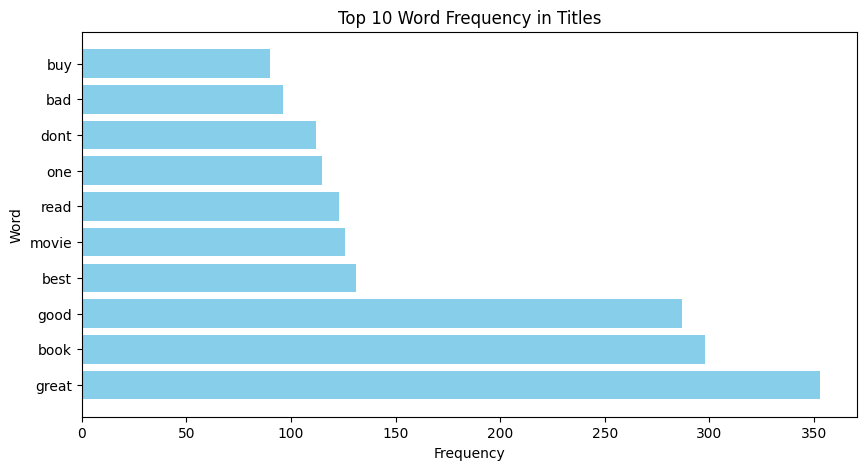

In [143]:
# Vizualizálás
plt.figure(figsize=(10, 5))
plt.barh(labels_title, counts_title, color='skyblue')
plt.title('Top 10 Word Frequency in Titles')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

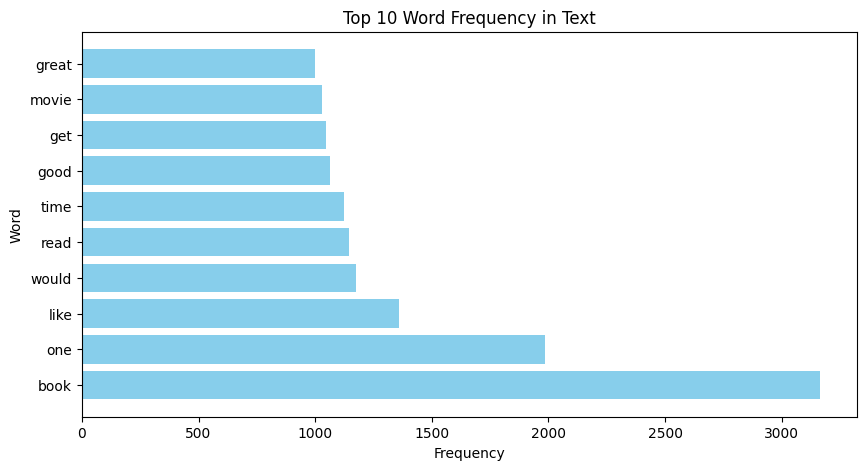

In [144]:
plt.figure(figsize=(10, 5))
plt.barh(labels, counts, color='skyblue')
plt.title('Top 10 Word Frequency in Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## Szófelhők


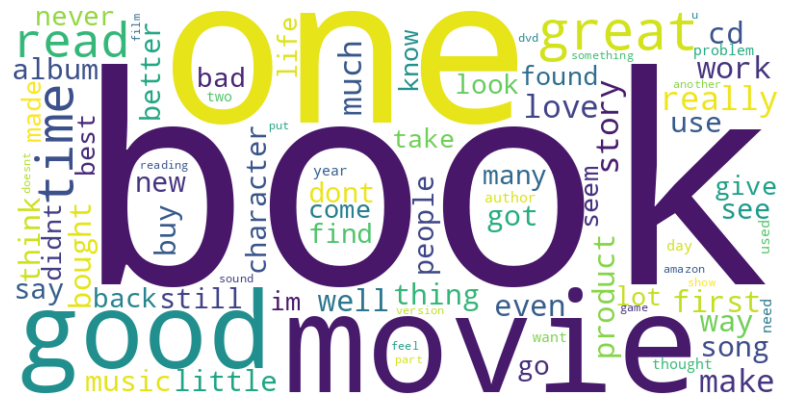

In [116]:
# Szófelhő generálása
text = " ".join(all_word)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words = 80).generate(text)

# Szófelhő megjelenítése
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

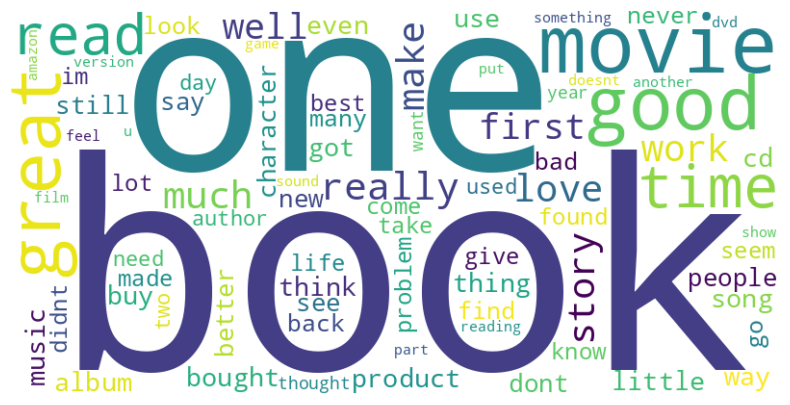

In [83]:
# Szófelhő generálása a title oszlopra
text2 = " ".join(all_word_title)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words = 80).generate(text2)

# Szófelhő megjelenítése
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#N-gram, bi-gram

In [103]:
# Bi-gramok készítése
word_pair_list = []
for item in data.select("text_tokens").collect():
  word_pairs = list(nltk.bigrams(item.text_tokens))
  for pair in word_pairs:
    word_pair_list.append(pair)

In [104]:
bigram_freq = Counter(word_pair_list)

In [105]:
print(bigram_freq.most_common(10))

[((" 'read'", " 'book'"), 143), ((" 'year'", " 'old'"), 105), ((" 'waste'", " 'money'"), 103), ((" 'would'", " 'recommend'"), 103), ((" 'year'", " 'ago'"), 75), ((" 'first'", " 'time'"), 74), ((" 'highly'", " 'recommend'"), 74), ((" 'book'", " 'read'"), 73), ((" 'dont'", " 'know'"), 71), ((" 'one'", " 'best'"), 65)]


In [106]:
# Tri-gramok készítése
word_pair_list3 = []
for item in data.select("text_tokens").collect():
  word_pairs = list(nltk.ngrams(item.text_tokens,3))
  for pair in word_pairs:
    word_pair_list3.append(pair)

In [107]:
trigram_freq = Counter(word_pair_list3)

In [108]:
print(trigram_freq.most_common(10))

[((" 'dont'", " 'waste'", " 'money'"), 40), ((" 'would'", " 'recommend'", " 'anyone'"), 20), ((" 'dont'", " 'waste'", " 'time'"), 19), ((" 'book'", " 'ever'", " 'read'"), 19), ((" 'year'", " 'old'", " 'son'"), 17), ((" 'would'", " 'recommend'", " 'book'"), 13), ((" 'worst'", " 'book'", " 'ever'"), 13), ((" 'book'", " 'ive'", " 'read'"), 13), ((" 'highly'", " 'recommend'", " 'book'"), 12), ((" 'recommend'", " 'book'", " 'anyone'"), 12)]


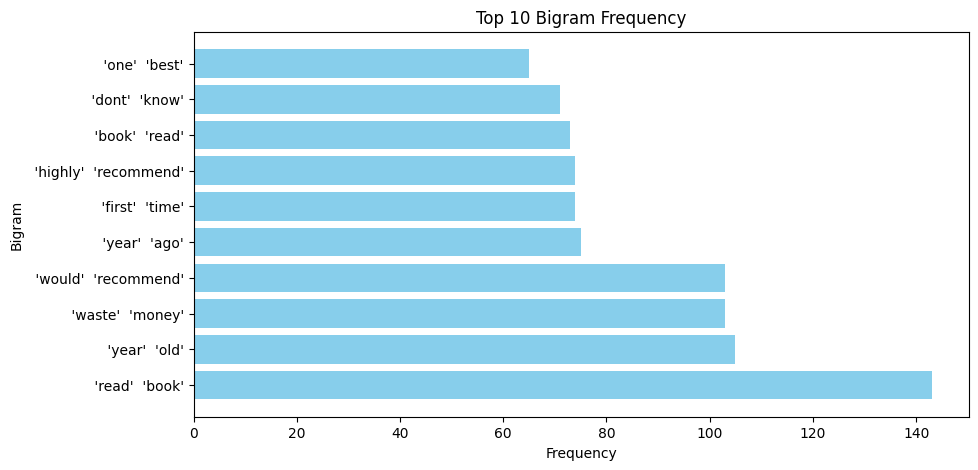

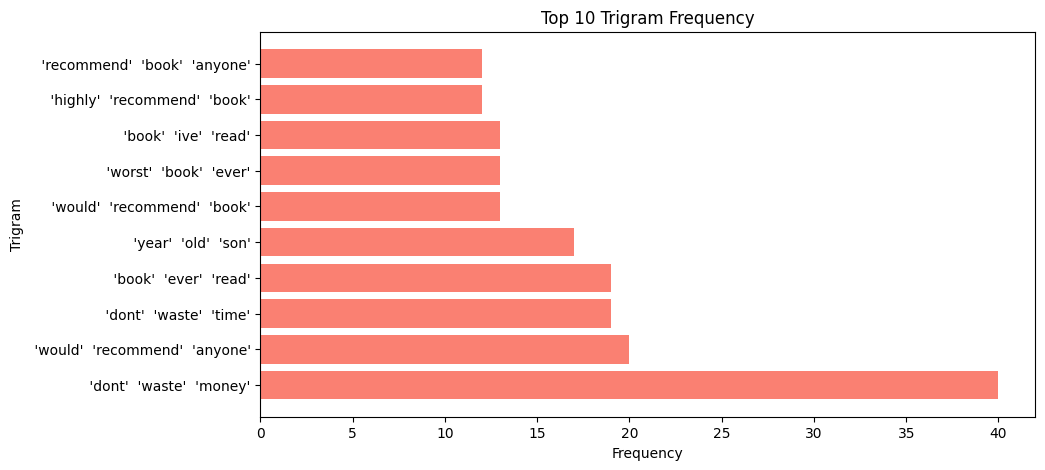

In [109]:
# Leggyakoribb bigramok és trigramok kiíratása és vizualizálása
bigram_list = bigram_freq.most_common(10)
trigram_list = trigram_freq.most_common(10)

# Bigramok vizualizálása
bigram_words, bigram_counts = zip(*bigram_list)
bigram_labels = [' '.join(bigram) for bigram in bigram_words]
plt.figure(figsize=(10, 5))
plt.barh(bigram_labels, bigram_counts, color='skyblue')
plt.title('Top 10 Bigram Frequency')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

# Trigramok vizualizálása
trigram_words, trigram_counts = zip(*trigram_list)
trigram_labels = [' '.join(trigram) for trigram in trigram_words]
plt.figure(figsize=(10, 5))
plt.barh(trigram_labels, trigram_counts, color='salmon')
plt.title('Top 10 Trigram Frequency')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

## Egyéb elemzési lehetőségek

In [167]:
# TF-IDF vektorizálás
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_word)

# Szavak és azok tf-idf értékei
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
#print(tfidf_df)

In [160]:
# Szavak átlagos tfidf értékeinek meghatározása és ebből a potenciálisan fontos szavak megadása
mean_tfidf_scores = tfidf_df.mean(axis=0)
important_words = mean_tfidf_scores.sort_values(ascending=False).head(10)

print(important_words)

book      0.016641
like      0.007153
read      0.006022
time      0.005917
good      0.005596
movie     0.005417
great     0.005249
dont      0.004213
really    0.004039
make      0.003703
dtype: float64


In [174]:
# Szöveg hosszának  elemzése
df_with_length = data.withColumn("text_length", length(data["text"]))

# Leghosszabb/rövidebb vélemény
max_length_row = df_with_length.orderBy(df_with_length["text_length"], ascending=False).first()

print("Legnagyobb hosszúságú szöveg:")
print(f"Szöveg: {max_length_row['text']}")
print(f"Hossz: {max_length_row['text_length']} karakter")

min_length_row = df_with_length.orderBy(df_with_length["text_length"], ascending=True).first()

print("\nLegkisebb hosszúságú szöveg:")
print(f"Szöveg: {min_length_row['text']}")
print(f"Hossz: {min_length_row['text_length']} karakter")

# Átlagos véleményhossz
avg_length = df_with_length.select(avg("text_length")).collect()[0][0]

print(f"\nÁtlagos karakterszám: {avg_length}")

Legnagyobb hosszúságú szöveg:
Szöveg: this album is able to be previewed in full on nmecom if i were you i would go there to find out just what youre about to endure this album sucks extremely bad i have not heard anything this half assed in all but two weeks this garbage getting good reviews is only an indication of the white reviewers out there trying to make this seem cooler than it isnnt the beats are exactly the same on every track handclaps and half rhythms are only one tenth of the awkwardness on this record i dont think that anyone with fully functioning ears would like this record unless they think it makes them look different for the most part there is nothing innovative on this record this is what bad pop music will sound like in ten years mia has recorded a travesty ahead of her time once again go to nmecom and preview this before you actully waste your money on this the sound of this record could have been reproduced with a kettle drum and sticks banging together in a long